## 데이터 불러오기 및 전처리


* 발주/입고 정보

In [5]:
# !pip install openpyxl

In [13]:
import pandas as pd
import numpy as np
import openpyxl

filename = '미트맵 입출고 내역(6-7월).xlsx'

# 엑셀 파일 읽어 오기
df = pd.read_excel(filename, sheet_name = '발주현황', engine='openpyxl', header = 1)

# 컬럼명 변환 (보관종류_고기부위)
df_col = df.iloc[0:2].fillna(method="ffill",axis = 1)
list_col = [str(df_col.values[0][i]) + '_'+ str(df_col.values[1][i]) for i in range(df_col.shape[1])]
list_col[3] = '구분' ## 중복 컬럼명 변경

# 불필요 데이터 제거 (공백칸, 누계. 일평균, 합계, 소계, 중량 등)
df = pd.DataFrame(data = df[8:].values, columns = list_col)
df = df.iloc[:,1:]
df.drop('구분_부위', axis = 1 , inplace = True)
df.drop('합계_부위', axis = 1 , inplace = True)
df.drop('냉장_소계', axis = 1 , inplace = True)

# 컬렴명 변환
df.rename(columns = {'일자_nan' : '일자'}, inplace = True)

# 데이터 변환
df['구분'] = df['구분'].apply(lambda x: x.split('(')[0])

# 결측치 채우기
df['일자'] = df['일자'].fillna(method = 'ffill', axis = 0)
df.fillna(0, inplace = True) # 발주/입고량 결측치 0으로 채우기

# 데이터 분류
order_df = df[df['구분'] == '발주'].reset_index(drop = True)
receve_df = df[df['구분'] == '입고'].reset_index(drop = True)

* 출고 정보

In [14]:
filename = '미트맵 입출고 내역(6-7월).xlsx'

# 엑셀 파일 읽어 오기
df = pd.read_excel(filename, sheet_name = '출고현황', engine='openpyxl', header = 2, index_col=0).T.reset_index(drop = True)

# 컬럼명 변환 (보관종류_고기부위)
df_col = df.iloc[0:3].fillna(method="ffill",axis = 1)
list_col = [str(df_col.values[0][i]) + '_'+ str(df_col.values[1][i]) + '_'+ str(df_col.values[2][i]) for i in range(df_col.shape[1])]

# 불필요 데이터 제거 (공백칸, 누계. 일평균, 합계, 소계, 중량 등)
df = pd.DataFrame(data = df[3:].values, columns = list_col)
df = df.iloc[5:-1]

# 컬렴명 변환
df.rename(columns = {'[ 제품 ]_50_작업' : '일자'}, inplace = True)
df.rename(columns = {'구분_부위_제품명' : '구분'}, inplace = True)

# 결측치 채우기
df['일자'] = df['일자'].fillna(method = 'ffill', axis = 0)
df.fillna(0, inplace = True) # 팩수/중량 결측치 0으로 채우기

# 데이터 분류
pack_df = df[df['구분'] == '팩수'].reset_index(drop = True)
weight_df = df[df['구분'] == '중량'].reset_index(drop = True)

## 데이터 EDA

* 발주 현황 데이터 EDA

In [15]:
# oder_df, receve_df

In [16]:
## 고기 종류 27개
order_col = ['냉장_미박삼겹', '냉장_삼겹', '냉장_목심', '냉장_뒷다리', '냉장_뒷사태', '냉장_앞다리', '냉장_등심꽃살', 
             '냉장_등심', '냉장_등심덧살', '냉장_등갈비', '냉장_갈비', '냉장_항정살', '냉장_안심', '냉장_갈매기살', 
             '냉장_토시살', '냉장_도깨비살', '냉동_소계', '냉동_뒷다리', '냉동_삼겹', '냉동_앞다리', '냉동_등심', 
             '냉동_목심', '냉동_갈비', '냉동_등뼈/찜용', '냉동_삼겹(자향)', '냉동_목심(자향_', '냉동_앞다리(자향)']
print(f"발주 제품 항목 : {len(order_col)}")
print()

발주 제품 항목 : 27



In [42]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

import matplotlib as mpl

#font 설정 파일 위치 출력
mpl.matplotlib_fname()

'/usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

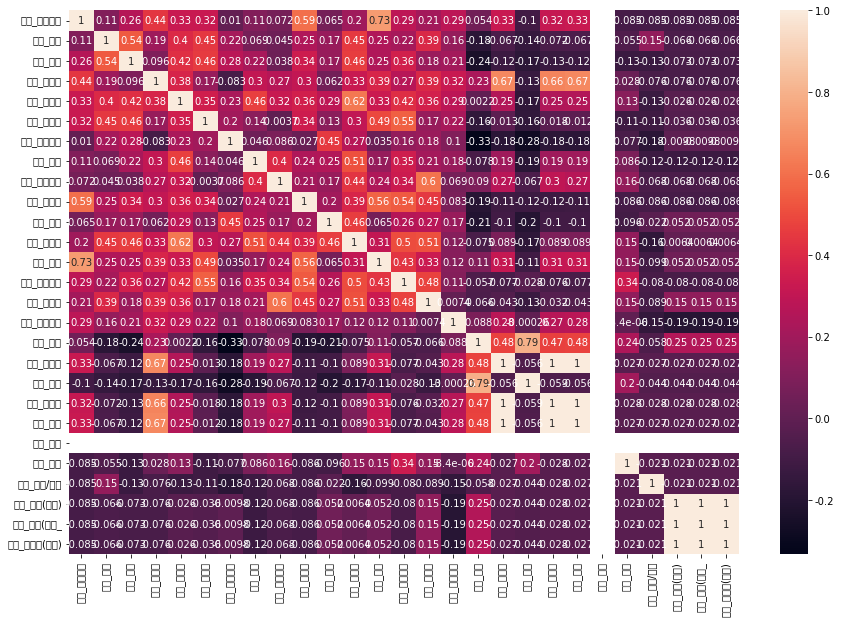

In [40]:
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize = (15,10))
sns.heatmap(order_df.corr(), annot=True)
plt.show()

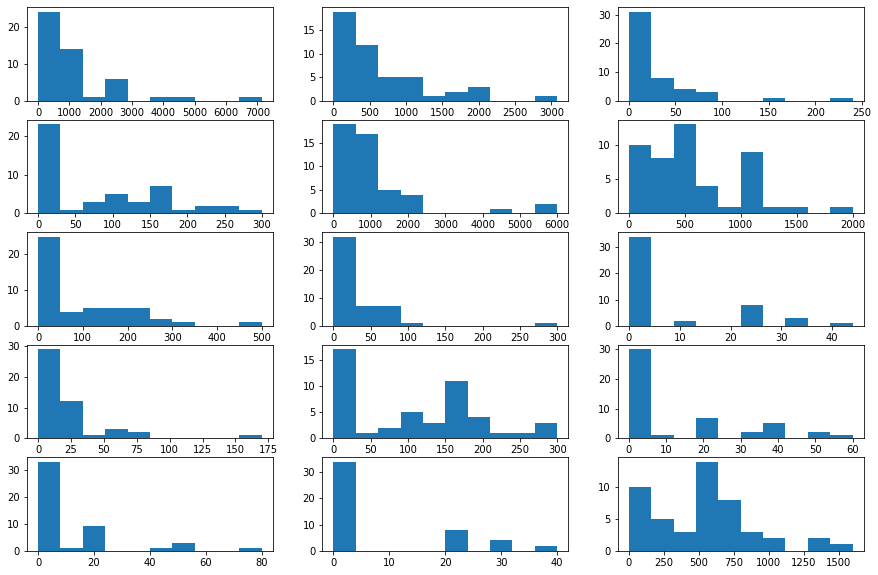

In [36]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] ='NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] =False

# for i in order_col:
#     print(i)
#     plt.hist(order_df[i])    
#     plt.show()
    

square_x = 5
square_y = 3
ix = 1
plt.figure(figsize=(15, 10)) 

for _ in range(square_x):
    for _ in range(square_y):
        ax = plt.subplot(square_x, square_y, ix)
        plt.hist(order_df[order_col[ix]])
        ix += 1
plt.show()

* 출고 현황 데이터 EDA
    - 중량 = 단량 * 팩수

## Forecast Test

In [18]:
# temp_list =[x for x in list(weight_df) if "냉장_삼겹" in x]
# temp_df.loc[:,'합계'] = temp_df.sum(axis = 1)

temp_list = ['냉장_삼겹_소계']
temp_list.insert(0, '일자')
temp_df = weight_df[temp_list]
temp_df['item_id'] = '냉장_삼겹'
temp_df.columns = ['timestamp', 'demand', 'item_id']

temp_df = temp_df[['item_id', 'timestamp', 'demand']]

temp_df.to_csv('forecast_냉장삼겹.csv', index = False)
temp_df.shape

<ipython-input-18-ac3ded87d608>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['item_id'] = '냉장_삼겹'


(50, 3)

In [19]:
n = 5
for i in range(n):
    temp_df[f'window_{i+1}'] = temp_df['demand'].shift(n-i)

train_col = [f'window_{i + 1}' for i in range(n)]
temp_x = temp_df[train_col]
temp_x.dropna(axis = 0, inplace = True)
temp_y = temp_df.loc[temp_x.index,'demand']

<ipython-input-19-9239266d1480>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_x.dropna(axis = 0, inplace = True)


In [21]:
## Data Split

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(temp_x, temp_y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(train_x, train_y)
model.score(train_x, train_y)

0.8689579153439347

In [23]:
model.score(test_x, test_y)

-0.32816415776726315

In [24]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test_y, model.predict(test_x))

0.5484028147448843

In [25]:
model = RandomForestRegressor()
model.fit(temp_x, temp_y)
print(model.score(temp_x, temp_y))
print(mean_absolute_percentage_error(temp_y, model.predict(temp_x)))

0.8737323046123024
0.22532628839640004


In [9]:
temp_x.shape

(45, 5)

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

K.clear_session()

temp = np.array(temp_x).reshape(45,1,-1)

model = Sequential([
    LSTM(4, input_shape = temp.shape[1:]),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 모델링
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K 
print(tf.__version__)
K.clear_session()

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))     
Adam = optimizers.Adam(learning_rate = 0.0001)

model = keras.Sequential([
    layers.Dense(scl_x.shape[1], activation='tanh', input_shape=[scl_x.shape[1]]),
    layers.Dense(64, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dense(16, activation='PReLU'),
    layers.Dense(1)
    
])
model.compile(loss=root_mean_squared_error, optimizer=Adam, metrics=['mse', 'mae'])
model.summary()
EPOCHS = 10
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, mode = 'auto')

history = model.fit(scl_x, train_y['rate'], epochs=EPOCHS, batch_size = 2,  validation_split = 0.2, verbose=1)
# # history = model.fit(scl_x, scl_y, epochs=EPOCHS, batch_size = 4,  validation_split = 0.1, verbose=1, callbacks=[early_stopping])

In [14]:
model.fit(temp, temp_y, batch_size = 4, verbose = 1)

InternalError: stream did not block host until done; was already in an error state

In [ ]:
!aws s3 cp forecast_냉장삼겹.csv s3://poc-2208-8meals/data/

In [ ]:
import boto3

session = boto3.Session() 
region = session.region_name
forecast = session.client(service_name="forecast") 
forecast_query = session.client(service_name="forecastquery")
s3 = session.client(service_name="s3")

In [19]:
datagroup_arn = forecast.list_dataset_groups()['DatasetGroups'][0]['DatasetGroupArn']
datagroup_arn

'arn:aws:forecast:ap-northeast-2:257832939543:dataset-group/test_8meals'

In [20]:
forecast.create_predictor(
    PredictorName='release_67_CNNQR',
    AlgorithmArn='arn:aws:forecast:::algorithm/CNN-QR',
    ForecastHorizon=13,
    InputDataConfig={
        'DatasetGroupArn': datagroup_arn,
        'SupplementaryFeatures': [{'Name': 'holiday', 'Value': 'KR'}],
    },
    FeaturizationConfig={
        'ForecastFrequency': 'D',
        'Featurizations': [
            {'AttributeName': 'demand'}
        ]
    }
)

ParamValidationError: Parameter validation failed:
Unknown parameter in FeaturizationConfig.Featurizations[0]: "Transformations", must be one of: AttributeName, FeaturizationPipeline